# Trabajo Practico II - Analisis Predictivo
## Abril Noguera

**Descargar la base:**

Uso la API de Kaggle

In [1]:
# !pip install kaggle

In [2]:
# !kaggle competitions download -c ap-2022q1
# !unzip ap-2022q1.zip

 96%|████████████████████████████████████▍ | 69.0M/71.8M [00:05<00:00, 18.9MB/s]
100%|██████████████████████████████████████| 71.8M/71.8M [00:05<00:00, 14.8MB/s]
Archive:  ap-2022q1.zip
  inflating: base_train.csv          
  inflating: base_val.csv            


In [2]:
import pandas as pd 

In [3]:
df_tr = pd.read_csv("base_train.csv")

In [4]:
df_te = pd.read_csv("base_val.csv")

**EDA:**

Base: 

La base de datos contiene informacion de las caracteristicas de distintos modelos de automoviles. 

Variables:
 - X: modelo
 - symboling: degree to which the auto is more risky than its price indicates. A value of +3 indicates that the auto is risky, -2 that it is probably pretty safe.
 - normalized.losses: relative average loss payment per insured vehicle year. El valor pesificado que pierde el auto cada año.
 - wheel.base: distance between the centres of the front and rear wheels.
 - length 
 - width
 - height
 - curb.weight: weight of the vehicle without any passenger or items in it except for the standard equipment that comes...
 - engine.size 
 - bore: the diameter of each cylinder of the piston engine. --> displacement = π ( 1/2 × bore )^2 × stroke × ncylinders
 - stroke: the distance travelled by the piston during each cycle.
 - compression.ratio: ratio between the volume of the cylinder and combustion chamber in an internal combustion engine at their maximum and minimum values. Cuantas veces mas aire hay cuando no hay presion que cuando hay presion.
 - horsepower 
 - peak.rpm: peak revolutions per minute. Measure of how fast any machine is operating at its peak.
 - city.mpg: average miles per gallon for your car in the city.
 - highway.mpg: average miles per gallon for your car in the highway.
 - price 

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [7]:
df_tr.columns

Index(['Unnamed: 0', 'symboling', 'normalized-losses', 'wheel-base', 'length',
       'width', 'height', 'curb-weight', 'engine-size', 'bore', 'stroke',
       'compression-ratio', 'horsepower', 'peak-rpm', 'city-mpg',
       'highway-mpg', 'price'],
      dtype='object')

In [8]:
df_tr.shape

(800000, 17)

In [9]:
df_tr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800000 entries, 0 to 799999
Data columns (total 17 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Unnamed: 0         800000 non-null  int64  
 1   symboling          800000 non-null  int64  
 2   normalized-losses  800000 non-null  float64
 3   wheel-base         800000 non-null  float64
 4   length             800000 non-null  float64
 5   width              800000 non-null  float64
 6   height             800000 non-null  float64
 7   curb-weight        800000 non-null  float64
 8   engine-size        800000 non-null  float64
 9   bore               800000 non-null  float64
 10  stroke             800000 non-null  float64
 11  compression-ratio  800000 non-null  float64
 12  horsepower         800000 non-null  float64
 13  peak-rpm           800000 non-null  float64
 14  city-mpg           800000 non-null  float64
 15  highway-mpg        800000 non-null  float64
 16  pr

<image src="/Users/anoguera/Desktop/Analisis\ Predictivo/Trabajo\ Practico\ 2/distribuciones.jpeg">

Las distribuciones son uniformes y normales. El precio podria ser una funcion lognormal.

**Split:**

Para la evaluacion de los modelos particiono la base con un 20% en test.

In [18]:
from sklearn.model_selection import train_test_split

In [19]:
import random
random.seed(10)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(df_tr.iloc[:,1:16], df_tr['price'], test_size=0.2)

print(X_train.shape), print(y_train.shape)
print(X_test.shape), print(y_test.shape)

(640000, 15)
(640000,)
(160000, 15)
(160000,)


(None, None)

**Arboles:**

In [13]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import r2_score

*   *Catboost:* 

Es un algoritmo de gradient boosting en arboles de decision. Su nombre se compone de 'Cat' y 'Boost'. Cat por Categories, porque este modelo es especialmente bueno para variables categoricas (no quiere decir que no es bueno para variables numericas). Esto es porque no se necesita normalizar las variables categoricas con One Hot Encoding previamente, usa algoritmos de Target Based Encoding. Y Boost porque es un algoritmo de gradient boosting.
Trata de extraer la maxima informacion posible de la base limitada, es decir, es buena para poca informacion. Y es rapido.

In [13]:
# pip install catboost

In [61]:
from catboost import CatBoostRegressor, Pool
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from catboost.utils import eval_metric

    Hiperparametros:

- Iterations: cantidad maxima de arboles que se construyen para resolver el problema de Machine Learning. --> Cuantas mas iteraciones mas overfitting, hay que contratarlo.
- Learning Rate: usado para reducir el gradient step. --> por defecto se define automaticamente segun las propiedades del dataset.
- Tree Depth: profundidad del arbol. --> se recomienda entre 6 y 10.
- L2 Regularization: probar cual es el mejor.
- Random Strength: que tan aleatorios van a ser los splits. --> se usa para prevenir el overfitting.
- Bagging Temperature: define los ajustes del Bayesian Bootstrap. Asigna pesos aleatorios a los objetos.
- Border Count: numero de splits de los factores numericos. --> para mejorar el tiempo de ejecucion, con e128 es suficiente pero 254 es la mejor.
- Internal Dataset Order: si se necesita un orden especifico no aplica aleatoriedad.
- Tree Growing Policy: los symetric trees son los mas rapidos.
- Golden Features: para resaltar algun factor que sea un fuerte predictor.

    Hiperparameters Search:
- Grid Search: recorre todas las combinaciones de hiperparametros posibles y elegir la mejor.
- Randomized Search: recorrer algunas de las combinaciones al azar.
- Optuna: usa algoritmos bayesianos donde a partir del intento anterior trata determina que hiperparametros seleccionar despues.

In [16]:
model = CatBoostRegressor(loss_function="RMSE")

In [21]:
train_dataset = Pool(X_train, y_train) 
test_dataset = Pool(X_test, y_test)

In [13]:
grid = {'iterations': [800, 1000],
        'learning_rate': [0.05, 0.1],
        'depth': [8, 10, 12],
        'l2_leaf_reg': [0.7, 1, 1.3]}
model.grid_search(grid, train_dataset)

0:	learn: 12282.2961191	test: 12297.4825555	best: 12297.4825555 (0)	total: 286ms	remaining: 3m 48s
1:	learn: 11741.1979022	test: 11755.1160613	best: 11755.1160613 (1)	total: 394ms	remaining: 2m 37s
2:	learn: 11229.9501152	test: 11243.7136857	best: 11243.7136857 (2)	total: 517ms	remaining: 2m 17s
3:	learn: 10745.2850585	test: 10758.7309763	best: 10758.7309763 (3)	total: 624ms	remaining: 2m 4s
4:	learn: 10287.7263761	test: 10300.5524769	best: 10300.5524769 (4)	total: 728ms	remaining: 1m 55s
5:	learn: 9857.6875136	test: 9870.7286887	best: 9870.7286887 (5)	total: 838ms	remaining: 1m 50s
6:	learn: 9451.7999613	test: 9464.5447702	best: 9464.5447702 (6)	total: 941ms	remaining: 1m 46s
7:	learn: 9069.1835151	test: 9081.5867298	best: 9081.5867298 (7)	total: 1.05s	remaining: 1m 44s
8:	learn: 8704.8105908	test: 8717.0290550	best: 8717.0290550 (8)	total: 1.18s	remaining: 1m 43s
9:	learn: 8362.0434044	test: 8374.0212327	best: 8374.0212327 (9)	total: 1.33s	remaining: 1m 44s
10:	learn: 8044.2618117	te

{'params': {'depth': 12,
  'l2_leaf_reg': 1,
  'iterations': 800,
  'learning_rate': 0.05},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               4

In [63]:
# 'depth': 12, 'l2_leaf_reg': 1, 'iterations': 800, 'learning_rate': 0.05
modelCBR4 = CatBoostRegressor(depth = 12, iterations = 800, learning_rate = 0.05, l2_leaf_reg = 1)

modelCBR4.fit(X_train, y_train, plot = True)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 5704.9065934	total: 149ms	remaining: 1m 59s
1:	learn: 5553.8131305	total: 235ms	remaining: 1m 33s
2:	learn: 5411.5857200	total: 335ms	remaining: 1m 29s
3:	learn: 5279.3534140	total: 408ms	remaining: 1m 21s
4:	learn: 5154.8731725	total: 484ms	remaining: 1m 17s
5:	learn: 5039.9963785	total: 563ms	remaining: 1m 14s
6:	learn: 4932.6409643	total: 645ms	remaining: 1m 13s
7:	learn: 4832.5085864	total: 727ms	remaining: 1m 11s
8:	learn: 4739.1759534	total: 792ms	remaining: 1m 9s
9:	learn: 4653.9078638	total: 853ms	remaining: 1m 7s
10:	learn: 4575.8778889	total: 926ms	remaining: 1m 6s
11:	learn: 4500.8049678	total: 997ms	remaining: 1m 5s
12:	learn: 4430.9883109	total: 1.06s	remaining: 1m 4s
13:	learn: 4366.9727164	total: 1.15s	remaining: 1m 4s
14:	learn: 4307.0464364	total: 1.22s	remaining: 1m 3s
15:	learn: 4252.1271241	total: 1.28s	remaining: 1m 2s
16:	learn: 4198.7619449	total: 1.34s	remaining: 1m 1s
17:	learn: 4149.7124988	total: 1.41s	remaining: 1m 1s
18:	learn: 4105.0459769	total:

In [ ]:
modelCBR4.score(X_test, y_test)

In [22]:
# 'depth': 12, 'l2_leaf_reg': 1, 'iterations': 800, 'learning_rate': 0.05
modelCBR4 = CatBoostRegressor(depth = 12, iterations = 800, learning_rate = 0.05, l2_leaf_reg = 1)

CBR4 = modelCBR4.fit(df_tr.iloc[:,1:16], df_tr['price'])

0:	learn: 5705.8981720	total: 177ms	remaining: 2m 21s
1:	learn: 5554.2699992	total: 244ms	remaining: 1m 37s
2:	learn: 5412.3940998	total: 306ms	remaining: 1m 21s
3:	learn: 5279.2554574	total: 368ms	remaining: 1m 13s
4:	learn: 5155.5654417	total: 433ms	remaining: 1m 8s
5:	learn: 5040.6328328	total: 502ms	remaining: 1m 6s
6:	learn: 4931.1684813	total: 566ms	remaining: 1m 4s
7:	learn: 4831.1315873	total: 630ms	remaining: 1m 2s
8:	learn: 4738.2278489	total: 697ms	remaining: 1m 1s
9:	learn: 4652.3424895	total: 782ms	remaining: 1m 1s
10:	learn: 4574.4697675	total: 849ms	remaining: 1m
11:	learn: 4499.7725244	total: 912ms	remaining: 59.9s
12:	learn: 4430.0861502	total: 978ms	remaining: 59.2s
13:	learn: 4366.7792969	total: 1.04s	remaining: 58.4s
14:	learn: 4307.7274907	total: 1.1s	remaining: 57.8s
15:	learn: 4253.3809012	total: 1.17s	remaining: 57.3s
16:	learn: 4200.8691176	total: 1.23s	remaining: 56.9s
17:	learn: 4153.8279809	total: 1.3s	remaining: 56.4s
18:	learn: 4107.9657023	total: 1.36s	re

In [62]:
print("\nTest  R2 : %.2f"%CBR4.score(X_test, y_test))
print("Train R2 : %.2f"%CBR4.score(X_train, y_train))


Test  R2 : 0.76
Train R2 : 0.76


In [ ]:

CBR4.calc_feature_statistics(X_train, y_train, feature="LSTAT")

---

Plot Tree:

In [76]:
# !pip install Graphviz
!sudo apt-get install graphviz

Password:
sudo: a password is required


In [74]:
from graphviz import Digraph, Graph

In [77]:
CBR4.plot_tree(
    tree_idx=0,
    pool=train_dataset
) # No logre instalar Graphviz

'CBR4.plot_tree(\n    tree_idx=0,\n    pool=train_dataset\n)'

---

Cross Validation:

In [78]:
from catboost import cv
from sklearn.model_selection import cross_val_predict

In [33]:
grid = {'iterations': 800,
        'learning_rate': 0.05,
        'depth': 12,
        'l2_leaf_reg': 1,
        'loss_function': "RMSE"}

In [34]:
scores = cv(train_dataset,
            grid,
            fold_count=10, 
            plot="True")

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/10]
0:	learn: 12279.9425845	test: 12282.8013557	best: 12282.8013557 (0)	total: 136ms	remaining: 1m 48s
1:	learn: 11734.5469097	test: 11737.9600759	best: 11737.9600759 (1)	total: 210ms	remaining: 1m 23s
2:	learn: 11218.6737478	test: 11223.6232500	best: 11223.6232500 (2)	total: 265ms	remaining: 1m 10s
3:	learn: 10730.5871580	test: 10736.4034466	best: 10736.4034466 (3)	total: 325ms	remaining: 1m 4s
4:	learn: 10270.2639276	test: 10276.8467313	best: 10276.8467313 (4)	total: 386ms	remaining: 1m 1s
5:	learn: 9837.5953302	test: 9845.0347449	best: 9845.0347449 (5)	total: 577ms	remaining: 1m 16s
6:	learn: 9428.4536488	test: 9436.3565021	best: 9436.3565021 (6)	total: 659ms	remaining: 1m 14s
7:	learn: 9042.3346567	test: 9050.9891713	best: 9050.9891713 (7)	total: 731ms	remaining: 1m 12s
8:	learn: 8676.3152695	test: 8685.9327039	best: 8685.9327039 (8)	total: 821ms	remaining: 1m 12s
9:	learn: 8333.3740488	test: 8343.6681147	best: 8343.6681147 (9)	total: 892ms	remaining: 1m 10s
10:

In [11]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from numpy import mean
from numpy import std

In [36]:
cv = KFold(n_splits=10, random_state=1, shuffle=True)

In [38]:
scores = cross_val_score(CBR4, X_train, y_train, scoring='r2', cv=cv, n_jobs=-1)

0:	learn: 5703.0385896	total: 1.06s	remaining: 14m 11s
0:	learn: 5706.5512084	total: 1.09s	remaining: 14m 28s
0:	learn: 5704.5172284	total: 1.06s	remaining: 14m 9s
0:	learn: 5703.9319637	total: 1.08s	remaining: 14m 21s
0:	learn: 5707.6559711	total: 1.1s	remaining: 14m 36s
0:	learn: 5704.6939428	total: 1.03s	remaining: 13m 43s
0:	learn: 5704.1194122	total: 835ms	remaining: 11m 7s
0:	learn: 5702.3456184	total: 929ms	remaining: 12m 22s
0:	learn: 5704.6245193	total: 1.08s	remaining: 14m 22s
1:	learn: 5554.3123656	total: 1.62s	remaining: 10m 47s
1:	learn: 5552.3805829	total: 1.6s	remaining: 10m 40s
0:	learn: 5707.5493577	total: 1.11s	remaining: 14m 46s
1:	learn: 5552.6339794	total: 1.63s	remaining: 10m 51s
1:	learn: 5552.2264851	total: 1.77s	remaining: 11m 47s
1:	learn: 5555.4615711	total: 1.72s	remaining: 11m 26s
1:	learn: 5551.6525878	total: 1.49s	remaining: 9m 54s
1:	learn: 5553.4088733	total: 1.64s	remaining: 10m 53s
1:	learn: 5552.6062784	total: 1.66s	remaining: 11m
1:	learn: 5552.0557

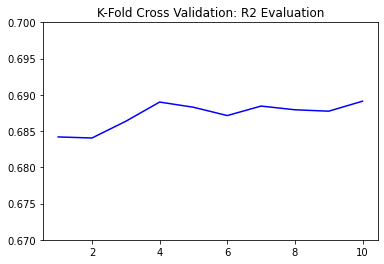

In [50]:
x = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
y = scores

plt.title("K-Fold Cross Validation: R2 Evaluation")
plt.plot(x, y, color="blue")
plt.ylim(0.67,0.70)
plt.show()

In [51]:
print('R2: %.3f (%.3f)' % (mean(scores), std(scores)))

R2: 0.687 (0.002)


0:	learn: 5707.6385318	total: 30.9ms	remaining: 24.7s
1:	learn: 5554.3180593	total: 62.1ms	remaining: 24.8s
2:	learn: 5411.7001961	total: 94.1ms	remaining: 25s
3:	learn: 5279.1545838	total: 128ms	remaining: 25.4s
4:	learn: 5156.6471857	total: 164ms	remaining: 26.1s
5:	learn: 5041.7697755	total: 196ms	remaining: 26s
6:	learn: 4938.5083773	total: 228ms	remaining: 25.9s
7:	learn: 4839.6008652	total: 262ms	remaining: 25.9s
8:	learn: 4743.4840298	total: 297ms	remaining: 26.1s
9:	learn: 4657.4992236	total: 330ms	remaining: 26.1s
10:	learn: 4576.0813982	total: 363ms	remaining: 26.1s
11:	learn: 4500.7475869	total: 395ms	remaining: 26s
12:	learn: 4429.2827928	total: 427ms	remaining: 25.8s
13:	learn: 4363.6000828	total: 459ms	remaining: 25.8s
14:	learn: 4303.6847632	total: 493ms	remaining: 25.8s
15:	learn: 4245.4047012	total: 540ms	remaining: 26.4s
16:	learn: 4192.0523907	total: 584ms	remaining: 26.9s
17:	learn: 4142.7859229	total: 617ms	remaining: 26.8s
18:	learn: 4094.3218400	total: 650ms	rema

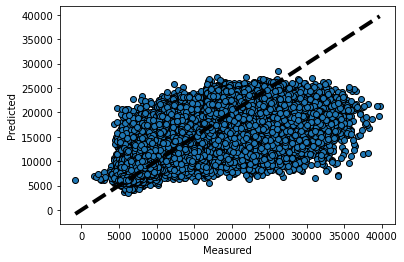

In [80]:
predicted = cross_val_predict(CBR4, X_test, y_test, cv=10)

fig, ax = plt.subplots()
ax.scatter(y_test, predicted, edgecolors=(0, 0, 0))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "k--", lw=4)
ax.set_xlabel("Measured")
ax.set_ylabel("Predicted")
plt.show()

---

Manteniendo CBR4 como base, voy a medir las variaciones en los parametros iteration y learning_rate.

In [19]:
fila = []

for i in range(500,2000,100):
  # 'depth': 12, 'l2_leaf_reg': 1, 'iterations': 800, 'learning_rate': 0.05
  regr2 = CatBoostRegressor(depth = 12, iterations = i, learning_rate = 0.05, l2_leaf_reg = 1)
  fregr2 = regr2.fit(X_train,y_train)
  r2_train = fregr2.score(X_train, y_train)
  r2_test = fregr2.score(X_test, y_test)
  fila.append([i,r2_train,r2_test])
  print(i)

0:	learn: 5705.6016522	total: 885ms	remaining: 7m 21s
1:	learn: 5553.4593502	total: 1.65s	remaining: 6m 50s
2:	learn: 5412.1084354	total: 2.52s	remaining: 6m 57s
3:	learn: 5278.8732844	total: 3.28s	remaining: 6m 46s
4:	learn: 5154.3371265	total: 3.91s	remaining: 6m 27s
5:	learn: 5039.1027814	total: 4.44s	remaining: 6m 5s
6:	learn: 4931.3729837	total: 4.91s	remaining: 5m 46s
7:	learn: 4831.0191171	total: 5.49s	remaining: 5m 37s
8:	learn: 4739.1060813	total: 6.02s	remaining: 5m 28s
9:	learn: 4653.5332598	total: 6.58s	remaining: 5m 22s
10:	learn: 4572.9013454	total: 7.31s	remaining: 5m 24s
11:	learn: 4498.1262021	total: 7.84s	remaining: 5m 19s
12:	learn: 4428.7322105	total: 8.46s	remaining: 5m 17s
13:	learn: 4365.8512237	total: 9.13s	remaining: 5m 17s
14:	learn: 4306.4248891	total: 9.68s	remaining: 5m 12s
15:	learn: 4251.9302949	total: 10.3s	remaining: 5m 12s
16:	learn: 4199.7905174	total: 11s	remaining: 5m 13s
17:	learn: 4150.1398061	total: 11.9s	remaining: 5m 18s
18:	learn: 4103.8168518

In [24]:
scores_profundidad = pd.DataFrame(fila, columns=["iteration","r2_train","r2_test"])
scores_profundidad

iteration  r2_train   r2_test
0         500  0.742495  0.686149
1         600  0.753434  0.686793
2         700  0.763224  0.687073
3         800  0.772301  0.687346
4         900  0.780846  0.687426
5        1000  0.788711  0.687525
6        1100  0.796191  0.687566
7        1200  0.803210  0.687549
8        1300  0.810082  0.687419
9        1400  0.816427  0.687283
10       1500  0.822162  0.687190
11       1600  0.827659  0.687072
12       1700  0.833117  0.686989
13       1800  0.838068  0.686810
14       1900  0.842926  0.686616

In [27]:
scores_profundidad_iterationCBR = scores_profundidad

Text(0.5, 0, 'Iteration')

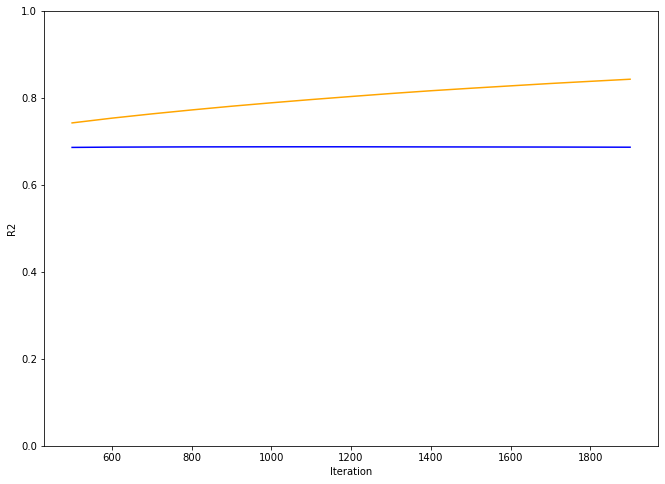

In [26]:
fig, ax = plt.subplots(figsize=(11,8))
ax = sns.lineplot(data=scores_profundidad_iterationCBR, x="iteration", y="r2_train", color = 'orange')
ax = sns.lineplot(data=scores_profundidad_iterationCBR, x="iteration", y="r2_test", color = 'blue')
ax.set_ylim(0,1)
ax.set_ylabel('R2')
ax.set_xlabel('Iteration')

El R2 se maximiza en test cuando las iteraciones son 1100. Revisemos que pasa con el learning_rate.

In [29]:
fila = []

for i in range(1,16,1):
  # 'depth': 12, 'l2_leaf_reg': 1, 'iterations': 800, 'learning_rate': 0.05
  regr2 = CatBoostRegressor(depth = 12, iterations = 600, learning_rate = i/100, l2_leaf_reg = 1)
  fregr2 = regr2.fit(X_train,y_train)
  r2_train = fregr2.score(X_train, y_train)
  r2_test = fregr2.score(X_test, y_test)
  fila.append([i,r2_train,r2_test])
  print(i)

0:	learn: 5836.3383010	total: 859ms	remaining: 8m 34s
1:	learn: 5803.9502066	total: 1.66s	remaining: 8m 15s
2:	learn: 5772.0556994	total: 2.43s	remaining: 8m 3s
3:	learn: 5740.4239345	total: 3.35s	remaining: 8m 19s
4:	learn: 5709.6055540	total: 4.11s	remaining: 8m 9s
5:	learn: 5678.6899208	total: 4.76s	remaining: 7m 50s
6:	learn: 5648.3558551	total: 5.42s	remaining: 7m 39s
7:	learn: 5618.1554496	total: 6.33s	remaining: 7m 48s
8:	learn: 5588.5172418	total: 7.17s	remaining: 7m 50s
9:	learn: 5559.5063500	total: 8.08s	remaining: 7m 56s
10:	learn: 5530.9318159	total: 8.65s	remaining: 7m 43s
11:	learn: 5502.5369954	total: 9.19s	remaining: 7m 30s
12:	learn: 5474.6975281	total: 9.79s	remaining: 7m 22s
13:	learn: 5446.9916252	total: 10.4s	remaining: 7m 14s
14:	learn: 5419.8128292	total: 11s	remaining: 7m 7s
15:	learn: 5393.1308340	total: 11.5s	remaining: 7m
16:	learn: 5366.6315420	total: 12.1s	remaining: 6m 54s
17:	learn: 5340.1697883	total: 12.7s	remaining: 6m 50s
18:	learn: 5314.2952993	total

In [32]:
scores_profundidad_learningrateCBR = pd.DataFrame(fila, columns=["learning_rate","r2_train","r2_test"])
scores_profundidad_learningrateCBR

learning_rate  r2_train   r2_test
0               1  0.679309  0.664756
1               2  0.706257  0.678916
2               3  0.724684  0.684049
3               4  0.740058  0.685848
4               5  0.753434  0.686793
5               6  0.764914  0.686821
6               7  0.774852  0.686234
7               8  0.783987  0.686364
8               9  0.793157  0.685397
9              10  0.802659  0.684737
10             11  0.809917  0.683760
11             12  0.816182  0.682735
12             13  0.823277  0.682077
13             14  0.830458  0.680307
14             15  0.836336  0.680004

Text(0.5, 0, 'learning_rate')

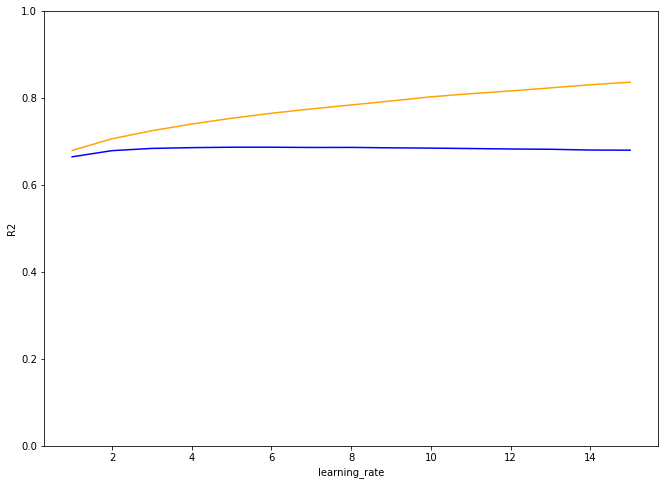

In [36]:
fig, ax = plt.subplots(figsize=(11,8))
ax = sns.lineplot(data=scores_profundidad_learningrateCBR, x="learning_rate", y="r2_train", color = 'orange')
ax = sns.lineplot(data=scores_profundidad_learningrateCBR, x="learning_rate", y="r2_test", color = 'blue')
ax.set_ylim(0,1)
ax.set_ylabel('R2')
ax.set_xlabel('learning_rate')

El R2 se maximiza en test cuando el learning_rate es 0.06.

In [ ]:
fila = []

for i in range(10,15,1):
  # 'depth': 12, 'l2_leaf_reg': 0.9, 'iterations': 1100, 'learning_rate': 0.06
  regr2 = CatBoostRegressor(depth = i, iterations = 1100, learning_rate = 0.06, l2_leaf_reg = 0.9)
  fregr2 = regr2.fit(X_train,y_train)
  r2_train = fregr2.score(X_train, y_train)
  r2_test = fregr2.score(X_test, y_test)
  fila.append([i,r2_train,r2_test])
  print(i)

0:	learn: 5681.9784803	total: 494ms	remaining: 9m 2s
1:	learn: 5507.7290302	total: 826ms	remaining: 7m 33s
2:	learn: 5348.0218191	total: 1.21s	remaining: 7m 23s
3:	learn: 5201.7617343	total: 1.53s	remaining: 6m 59s
4:	learn: 5069.4900390	total: 1.87s	remaining: 6m 49s
5:	learn: 4945.8194792	total: 2.15s	remaining: 6m 32s
6:	learn: 4836.1575490	total: 2.67s	remaining: 6m 57s
7:	learn: 4733.3530465	total: 3.21s	remaining: 7m 18s
8:	learn: 4640.2676034	total: 3.67s	remaining: 7m 25s
9:	learn: 4554.8363986	total: 4.07s	remaining: 7m 24s
10:	learn: 4476.5843479	total: 4.43s	remaining: 7m 18s
11:	learn: 4404.5994888	total: 4.72s	remaining: 7m 7s
12:	learn: 4338.2887246	total: 5.02s	remaining: 6m 59s
13:	learn: 4278.1090324	total: 5.29s	remaining: 6m 50s
14:	learn: 4222.6598259	total: 5.61s	remaining: 6m 45s
15:	learn: 4172.5778488	total: 6.04s	remaining: 6m 49s
16:	learn: 4127.6076319	total: 6.41s	remaining: 6m 48s
17:	learn: 4082.7526323	total: 6.71s	remaining: 6m 43s
18:	learn: 4043.144175

In [ ]:
scores_profundidad_depthCBR = pd.DataFrame(fila, columns=["depth","r2_train","r2_test"])
scores_profundidad_depthCBR

depth  r2_train   r2_test
0     10  0.742809  0.686172
1     11  0.772745  0.686483
2     12  0.811541  0.686749
3     13  0.855611  0.685115
4     14  0.902152  0.683098

Text(0.5, 0, 'depth')

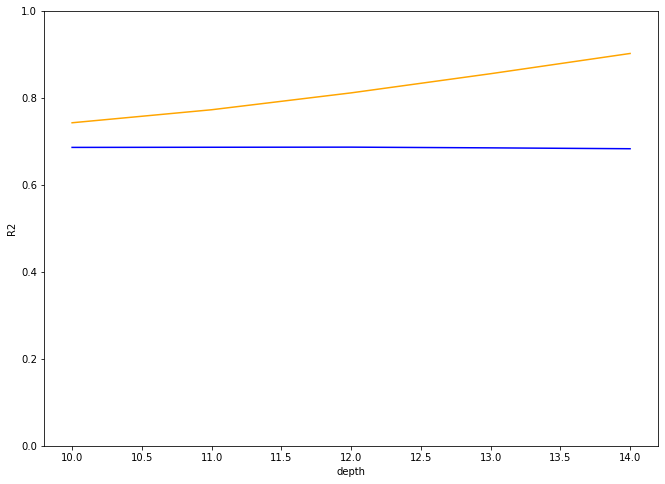

In [48]:
fig, ax = plt.subplots(figsize=(11,8))
ax = sns.lineplot(data=scores_profundidad_depthCBR, x="depth", y="r2_train", color = 'orange')
ax = sns.lineplot(data=scores_profundidad_depthCBR, x="depth", y="r2_test", color = 'blue')
ax.set_ylim(0,1)
ax.set_ylabel('R2')
ax.set_xlabel('depth')

La mejor depth es efectivamente 12.

Pruebo con el hiperparametro l2_leaf_reg.

In [49]:
fila = []

for i in range(7,13,1):
  # 'depth': 12, 'l2_leaf_reg': 0.9, 'iterations': 1100, 'learning_rate': 0.06
  regr2 = CatBoostRegressor(depth = 12, iterations = 1100, learning_rate = 0.06, l2_leaf_reg = i/10)
  fregr2 = regr2.fit(X_train,y_train)
  r2_train = fregr2.score(X_train, y_train)
  r2_test = fregr2.score(X_test, y_test)
  fila.append([i/10,r2_train,r2_test])
  print(i)

0:	learn: 5673.1623826	total: 833ms	remaining: 15m 15s
1:	learn: 5494.0726389	total: 1.56s	remaining: 14m 15s
2:	learn: 5329.6681469	total: 2.34s	remaining: 14m 15s
3:	learn: 5175.2088385	total: 3.23s	remaining: 14m 45s
4:	learn: 5035.3792240	total: 4.15s	remaining: 15m 9s
5:	learn: 4907.2121474	total: 5s	remaining: 15m 11s
6:	learn: 4790.4322267	total: 5.91s	remaining: 15m 23s
7:	learn: 4681.0707387	total: 6.75s	remaining: 15m 21s
8:	learn: 4583.4380547	total: 7.79s	remaining: 15m 44s
9:	learn: 4493.7322500	total: 8.89s	remaining: 16m 9s
10:	learn: 4412.0143782	total: 9.46s	remaining: 15m 36s
11:	learn: 4335.7030739	total: 10.2s	remaining: 15m 24s
12:	learn: 4266.0918911	total: 11s	remaining: 15m 21s
13:	learn: 4202.6258626	total: 11.9s	remaining: 15m 20s
14:	learn: 4144.7827278	total: 13s	remaining: 15m 41s
15:	learn: 4091.8708715	total: 13.9s	remaining: 15m 39s
16:	learn: 4042.6432710	total: 14.8s	remaining: 15m 40s
17:	learn: 3997.1962105	total: 15.4s	remaining: 15m 24s
18:	learn: 

In [50]:
scores_profundidad_l2_leaf_regCBR = pd.DataFrame(fila, columns=["l2_leaf_reg","r2_train","r2_test"])
scores_profundidad_l2_leaf_regCBR

l2_leaf_reg  r2_train   r2_test
0          0.7  0.813302  0.687070
1          0.8  0.812861  0.686561
2          0.9  0.811541  0.686749
3          1.0  0.811390  0.686909
4          1.1  0.810212  0.686349
5          1.2  0.809398  0.687107

Text(0.5, 0, 'l2_leaf_reg')

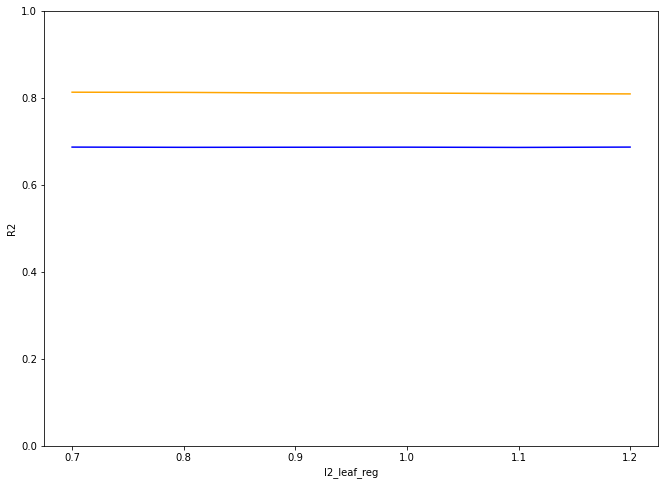

In [51]:
fig, ax = plt.subplots(figsize=(11,8))
ax = sns.lineplot(data=scores_profundidad_l2_leaf_regCBR, x="l2_leaf_reg", y="r2_train", color = 'orange')
ax = sns.lineplot(data=scores_profundidad_l2_leaf_regCBR, x="l2_leaf_reg", y="r2_test", color = 'blue')
ax.set_ylim(0,1)
ax.set_ylabel('R2')
ax.set_xlabel('l2_leaf_reg')

**Salida:**

In [17]:
# Salida CatBoost 4
pred = CBR4.predict(df_te.iloc[:,1:16])

salida = pd.DataFrame(data={"price": pred}).astype(str)
salida.index = df_te.iloc[:,0]
salida.to_csv("catBoost4.csv", sep=',',index=True,  index_label='id')

# Score: 0.69186